<a href="https://colab.research.google.com/github/spatank/CIS-545/blob/master/Homework_2_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Homework 2
## Due 12 October, 2020 by 10pm Eastern Time
### Worth 100 points in total

Welcome to Homework 2! By now, you should be familiar with the world of data science and the Pandas library. This assignment will focus on broadening both of these horizons by covering hierarchical data, graphs, and traversing relationships as well as two new tools: SQL and Spark. 

In the first section, we will familiarize ourselves with SQL (specifically **pandassql** and explore the Stack Exchange dataset. We will also finish out the section with some text analysis.

The second section will focus on graph data and give you a small preview of Spark using the Yelp dataset. This homework is designed to introduce you to Spark's required workflow before you fully unlease its power next homework and deploy it on an AWS cluster. 

We are introducing a lot of new things in this homework, and it is often where students start to get lost in the data science sauce, so we **strongly** encourage you to review the slides/material as you work through this assignment and will try to link the most relevant sections!

**Before you Begin**
- Be sure to click "Copy to Drive" to make sure you are working on your own personal version of the homework
- Read the Piazza and FAQ for updates! If you have been stuck, chances are other students are too! We don't want you to waste away for two hours trying to get that last point on the autograder so do check Piazza for similar struggles or even homework bugs that will be clarified in the FAQ :) 

# Section 0: Homework Initialization

## Part -2: Install the Proper Version of Pandas

Run the following cell to install the proper version of pandas. After running this cell, restart your runtime (Runtime > Restart runtime) and then run all the remaining set up cells. 

In [1]:
!pip3 install pandas==1.0.5

In [2]:
# make sure that this cell prints True! Otherwise you may have forgotten to
# restart your runtime after running the cell above
import pandas as pd
print(pd.__version__ == '1.0.5')

True


## Part -1: Enter your PennID

In [3]:
STUDENT_ID =  22993135

## Part 0: Libraries and Set Up Jargon (The usual wall of imports)

In [4]:
#! sudo apt install openjdk-8-jdk
#! sudo update-alternatives --config java

In [5]:
!pip3 install penngrader

from penngrader.grader import *

In [6]:
grader = PennGrader(homework_id = 'CIS545_Fall_2020_HW2', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 22993135

Make sure this correct or we will not be able to store your grade


In [7]:
### Install required packages
%%capture
!pip3 install lxml
!pip install pandasql
!pip install googledrivedownloader

In [8]:
import numpy as np
import matplotlib

import gc
import time
import warnings

import json # JSON parsing
from lxml import etree # HTML parsing
import time # Time conversions
from lxml import etree # XML Parser
import pandasql as ps # SQL on Pandas Dataframe

import nltk
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.




# Section 1: Exploring the Stack Exchange Dataset


<img src = "https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/se/se-logo.png?v=dd7153fcc7fa" width= "600" align ="center"/>

To survive as a student at Penn , you've certainly used Stack Exchange or Stack Overflow, as a source for all your technical queries. Stack Exchange looks a lot like a social network, it has the following pieces of information to tie it all together:


*   Users: All stack exchange users including admins etc.

*   Posts: All the questions as well as the answers that users post

*   Comments: As the name suggests, these are comments on posts

*   Votes: Up/Downvotes 


For this homework we'll be parsing this data (dumped in XML) into dataframes and relations, and then exploring how to query and assemble the tables into results with Pandas and  PandaSQL.

## Part 1: Loading our datasets [12 points total]

Before we get into the data, we first need to load our datasets. We will actually only be using the Users and Posts datasets for our queries, but we want you to write a generalized xml parsing function that would be able to convert any of the xml files into a dataframe.

### 1.0 Importing Data

Below is the code to import the xml files from our shared Google Drive. The data is relatively small, so this shouldn't take too long. We will only import the Users and Posts xmls for now, but the other datasets are there in case you want to take a look :)

In [9]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1T-SGFULQIkpg6LN5XLhBfiXhcAWNgCLe',
                                    dest_path='/content/Users.xml')

gdd.download_file_from_google_drive(file_id='1etuY-EjzgEfMdPCSd7NblNz0qJJpAH3b',
                                    dest_path='/content/Posts.xml')

### 1.1 Load Dataset Function

Now that we finally have all our packages imported and datasets initalized, it's time to finally write some code! Your first task is to write the function **xml_to_df(file_path)** that will parse the specified file into a dataframe. This function should be generalized, in the sense that it can accept any of the xml files that we loaded and return a dataframe. We highly recommend looking over the [xml documentation](https://docs.python.org/2/library/xml.etree.elementtree.html) in order to accomplish this task.

**TODO:** Once you have written **xml_to_df(file_path)**, create a **posts_df** and **users_df** with the parsed XML files (`/content/Users.xml` and `/content/Posts.xml`)

Tip: try figuring out the steps with one of the two XML files first! 

In [10]:
!ls

Posts.xml  sample_data	Users.xml


In [11]:
def xml_to_df(file_path):
  """ Converts an xml file to a dataframe

  :param file_path: path to file
  :return: dataframe 
  """
  
  tree = etree.ElementTree()
  tree.parse(file_path)
  root = tree.getroot()
  lst = []
  for child in root:
    child_dict = dict(child.attrib)
    lst.append(child_dict)

  df = pd.DataFrame(lst)

  return df

In [12]:
posts_df = xml_to_df('Posts.xml')

In [13]:
# [CIS 545 PennGrader Cell] - 5 points
grader.grade(test_case_id = 'test_xml_to_posts_df', answer = posts_df[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [14]:
users_df = xml_to_df('Users.xml')

In [15]:
grader.grade(test_case_id = 'test_xml_to_users_df', answer = users_df[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2 Clean Dataset

Next, we are going to want to clean up our dataframes, namely 1) removing null values,  2) changing datatypes, and 3) dropping columns

Originally, we were going to have you identify the datatypes with this [image](https://i.stack.imgur.com/AyIkW.png) on your own, but I (the TA writing this section) found this part really tedious and rage-inducing so we have defined the specific columns to convert below. All you need to do is write the function :)

**TODO**: 1) replace all null values in both datasets **in-place**. 2) define a function **dtype_converter(df, int_columns)** that takes in a dateframe and a list specifying which columns should be integers. Then, use this function on both posts_df and users_df using the lists defined below. (Note: we don't need to convert any columns to strings since they're already objects, and we're ignoring datetime)

In [16]:
posts_df.fillna(0, inplace = True)
users_df.fillna(0, inplace = True)

In [17]:
# columns that need to be integers

int_posts_cols = ["Id", "PostTypeId", "AcceptedAnswerId", "ParentId", "Score", 
                  "ViewCount", "OwnerUserId", "LastEditorUserId", "AnswerCount",
                  "CommentCount", "FavoriteCount"]
int_users_cols = ["Id", "Reputation", "Views", "UpVotes", "DownVotes", "AccountId"]

In [18]:
def dtype_converter(df, int_columns):
  """converts columns to type integer

  :param df: dataframe to convert
  :param int_columns: list of columns to convert
  :return: dataframe
  """
  change_dict = {}
  for key in int_columns:
    change_dict[key] = int
  
  df = df.astype(change_dict)

  return df

In [19]:
posts_df = dtype_converter(posts_df, int_posts_cols) 
users_df = dtype_converter(users_df, int_users_cols) 

In [20]:
# check your datatypes
posts_df.dtypes 

Id                        int64
PostTypeId                int64
CreationDate             object
Score                     int64
ViewCount                 int64
Body                     object
OwnerUserId               int64
LastActivityDate         object
Title                    object
Tags                     object
AnswerCount               int64
CommentCount              int64
FavoriteCount             int64
ClosedDate               object
AcceptedAnswerId          int64
LastEditorUserId          int64
LastEditDate             object
ParentId                  int64
OwnerDisplayName         object
CommunityOwnedDate       object
LastEditorDisplayName    object
dtype: object

In [21]:
grader.grade(test_case_id = 'test_posts_dtypes', answer = posts_df[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [22]:
grader.grade(test_case_id = 'test_users_dtypes', answer = users_df[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 1.5 Your Sandbox 

Instead of throwing you straight into the deep end, we wanted to give you a chance to take some time and explore the data on your own. **This section is not graded**, so for the speedrunners out there feel free to just jump in, but we wanted to at least give you a small space to utilize your basic EDA toolkit to familiarize yourself with all the info you just downloaded.

Some suggestions to get you started:
- `df.head()`
- `df.info()`
- `df.describe()`

Also, definitely take a look at [this readme](https://ia800107.us.archive.org/27/items/stackexchange/readme.txt) that provides a good overview of all the datasets (ignore the ones that you did not ask you to convert)


In [23]:
# your EDA here! feel free to add more cells

## Part 2: Exploring the data with Pandas and PandasSQL [20 points total]

Now that you are familiar (or still unfamiliar) with the dataset, we will now introduce you to SQL, or more specifically **pandasql**: a package create to allow users to query pandas DataFrames with SQL statements.

The typical flow to use pandasql (shortened to **ps**) is as follows:
1. write a SQL query in the form of a string (Tip: use triple quotes """x""" to write multi-line strings)
2. run the query using **ps.sqldf(your_query, locals())**

Pandasql is convenient in that it allows you to reference the dataframes that are currently defined in your notebook, so you will be able to fully utilize the `posts_df` and `users_df` that you have created above!

Given that it is a brand new language, we wanted to give you a chance to directly compare the similarities/differences of the pandas that you already know and the SQL you are about to learn. Thus, for each query, we ask that you to **look into the question twice: once with pandas and once with pandasql**. 

Each answer will thus require both a `pd_` and `sql_` prefixed-dataframe that you will submit seperately to the autograder. **We will be reviewing your code to make sure you wrote the code in the corresponding languages.**

 [Here](https://community.alteryx.com/t5/Data-Science/pandasql-Make-python-speak-SQL/ba-p/138435) is a good resource to review pandasql. 



### 2.1 Spliting Up `posts_df`

`posts_df` actually contains both posted questions and the answers. The provided readme details the distinguishing factors as follows:

        - PostTypeId
            - 1: Question
            - 2: Answer
        - ParentID (only present if PostTypeId is 2)
        - AcceptedAnswerId (only present if PostTypeId is 1)

**TODO:** Using pandas/pandasql, split `posts_df` into a `pd/sql_questions_df` and `pd/sql_answers_df` based on these values of `PostTypeId`. 



In [24]:
pd_questions_df = posts_df[posts_df['PostTypeId'] == 1] 
pd_answers_df = posts_df[posts_df['PostTypeId'] == 2] 

In [25]:
grader.grade(test_case_id = 'test_pd_questions_df', answer = pd_questions_df["PostTypeId"].values)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [26]:
grader.grade(test_case_id = 'test_pd_answers_df', answer = pd_answers_df["PostTypeId"].values)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [27]:
questions_query = "SELECT * FROM posts_df WHERE PostTypeId = 1"
answers_query = "SELECT * FROM posts_df WHERE PostTypeId = 2"

sql_questions_df = ps.sqldf(questions_query)
sql_answers_df = ps.sqldf(answers_query)

In [28]:
grader.grade(test_case_id = 'test_qa_query', answer = (questions_query, answers_query))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [29]:
# using just our sql dataframe moving forward
questions_df = sql_questions_df
answers_df = sql_answers_df

### 2.2 What are the most popular questions?

**TODO**: Use `questions_df` to find the 10 most popular questions by `ViewCount`.

Store the results in `pd/sql_popular_df` which be have the following format:

>Id | Title | ViewCount
>--- | --- | ---

Hint: for your SQL query, you will need to know `ORDER BY`, `LIMIT`

In [30]:
pd_popular_df = questions_df[['Id', 'Title', 'ViewCount']].sort_values(\
                                                                       by = 'ViewCount', ascending = False).iloc[:10]
pd_popular_df

,Id,Title,ViewCount
235,893,How to get correlation between two categorical...,202040
969,6107,What are deconvolutional layers?,180519
3094,13490,How to set class weights for imbalanced classe...,167923
7,22,K-Means clustering for mixed numeric and categ...,167107
2051,10459,Calculation and Visualization of Correlation M...,160305
2705,12321,Difference between fit and fit_transform in sc...,158049
2563,11928,"ValueError: Input contains NaN, infinity or a ...",143746
9254,33053,How do I compare columns in different data fra...,139491
1626,9302,The cross-entropy error function in neural net...,134651
3868,15989,Micro Average vs Macro average Performance in ...,115817


In [31]:
grader.grade(test_case_id = 'test_pd_popular_df', answer = pd_popular_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [32]:
popular_query = 'SELECT Id, Title, ViewCount FROM questions_df ORDER BY ViewCount DESC LIMIT 10'
sql_popular_df = ps.sqldf(popular_query)
sql_popular_df

,Id,Title,ViewCount
0,893,How to get correlation between two categorical...,202040
1,6107,What are deconvolutional layers?,180519
2,13490,How to set class weights for imbalanced classe...,167923
3,22,K-Means clustering for mixed numeric and categ...,167107
4,10459,Calculation and Visualization of Correlation M...,160305
5,12321,Difference between fit and fit_transform in sc...,158049
6,11928,"ValueError: Input contains NaN, infinity or a ...",143746
7,33053,How do I compare columns in different data fra...,139491
8,9302,The cross-entropy error function in neural net...,134651
9,15989,Micro Average vs Macro average Performance in ...,115817


In [33]:
grader.grade(test_case_id = 'test_popular_query', answer = popular_query)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [34]:
grader.grade(test_case_id = 'test_sql_popular_df', answer = sql_popular_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3 Who are the most helpful users?

**TODO:**  Use `answers_df` to find the names of the top 10 users who answer the most questions on stack exchange. This should be based on the count of unique answers made by the user.

Your answer, stored in `pd/sql_talkative_df` will have the following format:

>UserId | DisplayName | ResponseCount
>--- | --- | ---


Note: both `users_df` and `answers_df` have an `Id` column, but store entirely different values in them! 

SQL Hint: The tools that you will need include, but are not limited to`AS`, `JOIN`, `GROUP BY`, `ORDER BY` and `LIMIT`

In [35]:
users_answers_df = users_df.merge(answers_df, left_on = 'Id', right_on = 'OwnerUserId')
answers_by_users = users_answers_df.groupby(['Id_x', 'DisplayName']).size().sort_values(ascending = False).iloc[:10].to_frame()
answers_by_users.reset_index(inplace = True)
mapping = {answers_by_users.columns[0]: 'UserId', answers_by_users.columns[2]: 'ResponseCount'} 
answers_by_users.rename(columns = mapping, inplace = True)
pd_talkative_df = answers_by_users

In [36]:
pd_talkative_df

,UserId,DisplayName,ResponseCount
0,836,Neil Slater,408
1,45264,n1k31t4,363
2,924,Anony-Mousse,345
3,28175,Media,330
4,1330,Brian Spiering,270
5,381,Emre,227
6,64377,Erwan,221
7,29587,JahKnows,203
8,14904,Jan van der Vegt,184
9,67328,Esmailian,152


In [37]:
grader.grade(test_case_id = 'test_pd_talkative_df', answer = pd_talkative_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [38]:
talkative_query = \
'''
SELECT users_df.Id AS UserId, 
users_df.DisplayName AS DisplayName,
COUNT(users_df.Id) AS ResponseCount
FROM users_df INNER JOIN answers_df ON users_df.Id = answers_df.OwnerUserId 
GROUP BY users_df.Id 
ORDER BY COUNT(users_df.Id) DESC LIMIT 10
'''
sql_talkative_df = ps.sqldf(talkative_query)
sql_talkative_df

,UserId,DisplayName,ResponseCount
0,836,Neil Slater,408
1,45264,n1k31t4,363
2,924,Anony-Mousse,345
3,28175,Media,330
4,1330,Brian Spiering,270
5,381,Emre,227
6,64377,Erwan,221
7,29587,JahKnows,203
8,14904,Jan van der Vegt,184
9,67328,Esmailian,152


In [39]:
grader.grade(test_case_id = 'test_talkative_query', answer = talkative_query)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [40]:
grader.grade(test_case_id = 'test_sql_talkative_df', answer = sql_talkative_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.4 Who are the most helpful-in-a-different-kind-of-way users?

**TODO**: find the users that ask a lot of questions, but have never posted an answer. To accomplish this, you are going to want to find all the users in `questions_df` that don't appear in `answers_df`. Sort by `QuestionsCount` descending and store only the top 5 results.

The query will require you to write a [nested SQL query](https://learnsql.com/blog/sql-nested-select/). That is, there will be at least one select statement inside of a select statement. This means that you **should NOT** write two seperate SQL commands and call ps.sqldf() twice. 

Though it would be helpful, **you do NOT have to implement this in pandas**. Your answer, stored in `askers_df` will have the following format:

>UserId | DisplayName | QuestionsCount
>--- | --- | ---


SQL Hint: You can use `NOT IN` or `LEFT JOIN`.

In [41]:
askers_query = \
'''
SELECT users_df.Id AS UserId,
users_df.DisplayName as DisplayName,
COUNT(users_df.Id) AS QuestionsCount
FROM users_df INNER JOIN
(
  SELECT *
  FROM questions_df
  WHERE questions_df.OwnerUserId NOT IN
  (SELECT answers_df.OwnerUserId FROM answers_df)
) q_not_a
ON users_df.Id = q_not_a.OwnerUserId
GROUP BY users_df.Id 
ORDER BY COUNT(users_df.Id) DESC LIMIT 5
'''

askers_df = ps.sqldf(askers_query)
askers_df

,UserId,DisplayName,QuestionsCount
0,17310,Edamame,42
1,51129,N.IT,38
2,8013,girl101,36
3,58433,user10296606,32
4,7812,william007,29


In [42]:
grader.grade(test_case_id = 'test_askers_query', answer = askers_query)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [43]:
grader.grade(test_case_id = 'test_askers_df', answer = askers_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.5 So which is better, SQL or Pandas?

Now that you have a taste for SQL, let's try to use our new skill to query stack exchange in this notebook and put this debate to rest.

**TODO**: Find all of the answers to a post that asks about Pandas vs. SQL. Here are some clues that will come in handy:
1. This post contains the words "pandas" and "sql"
2. This post has the most viewcount out of all the posts with both of those words
3. The answers to this post have the column `ParentId` equal to the post's `Id`

Again, no need to do this in pandas, but your answer, stored in `versus_df` will have the following format:

> QuestionId | Question | QuestionBody | AnswerId | AnswerBody 
>--- | --- | --- | --- | ---

SQL Hint: take a look at the `LIKE` function


In [44]:
versus_query = \
'''
SELECT query_1.Id AS QuestionId,
query_1.Title AS Question,
query_1.Body as QuestionBody,
answers_df.Id as AnswerId,
answers_df.Body as AnswerBody
FROM answers_df INNER JOIN 
(
  SELECT *
  FROM questions_df
  WHERE Title LIKE '%pandas%' AND Title LIKE '%sql%'
  ORDER BY questions_df.ViewCount DESC LIMIT 1
) query_1
ON answers_df.ParentId == query_1.Id
'''
versus_df = ps.sqldf(versus_query)
versus_df

,QuestionId,Question,QuestionBody,AnswerId,AnswerBody
0,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",34359,"<p>First, pandas is not that much popular. I u..."
1,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",34366,<p>The real first question is why are people m...
2,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",34369,<p>I'm one of those people who would use (in m...
3,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",34375,<p>As much as there is overlap in the applicat...
4,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",34383,<p>The only thing not covered in these answers...
5,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",34445,<p>I thought I would add that I do a lot of ti...
6,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",35621,"<h2>Things Pandas can do, that SQL can't do</h..."
7,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",40881,<p>I'll attempt to answer this question based ...
8,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",45701,<p>I'm fairly new to Pandas/Python but have 20...
9,34357,Why do people prefer Pandas to SQL?,"<p>I've been using SQL since 1996, so I may be...",46446,<p>Panda is more popular since python in the f...


We highly recommend that you read the responses! They are actually all pretty accurate and go into the pros/cons that you probably encountered while working through the problem set. Use `pd.set_option('display.max_colwidth', -1)` to view the full columns and when you're done set the colwidth back to a value like `20` so that you don't have giant dataframes in the next steps.

(You could also try to find the same question via Google Search)

In [45]:
# pd.set_option('display.max_colwidth', 20)
# versus_df

In [46]:
grader.grade(test_case_id = 'test_versus_query', answer = versus_query)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [47]:
grader.grade(test_case_id = 'test_versus_df', answer = versus_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 3: Working with Text Data [22 points]

Shifting gears, let's now try to do some text-based analysis. Our Stack Exchange data has plenty of text that we can play with, from the user descriptions to the posts themselves. Text data is complex, but can also be used to generate extremely interpretable results, making it valuable and interesting. 

Throughout this section, we will attempt to answer the following:

### What types of questions should I ask to get a higher reputation on Stack Exchange? 

Users on stack exchange are valued based on their reputation, which depends on the quality of your posts. Each post receives a score, where **score = number of upvotes - number of downvotes**. This value is already present in your posts_df. 

Both questions and answers get scores, but let's just focus on what types of questions we should/shouldn't ask in order to get a higher score and thus higher reputation.


### 3.1 Getting Highest and Lowest Scored Posts
**TODO:** First, let's get questions with the negative scores from `questions_df` and then get the **same number** of questions with highest scores. Convert the **Body** column of the highest/lowest scorers into two lists: **highest_content** and **lowest_content**. Be sure to sort when needed!

Feel free to use either **pandas** or **pandasql** to accomplish this :)

In [48]:
lowest_query = \
'''
SELECT Body
FROM questions_df
WHERE Score < 0
ORDER BY Score
'''

lowest_content_df = ps.sqldf(lowest_query)
highest_content_df = questions_df.sort_values(by = 'Score', ascending = False).head(len(lowest_content_df))

In [49]:
lowest_content = lowest_content_df['Body'].to_list()
highest_content = highest_content_df['Body'].to_list()

In [50]:
grader.grade(test_case_id = 'test_lowest_content', answer = lowest_content)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [51]:
grader.grade(test_case_id = 'test_highest_content', answer = highest_content)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2 Cleaning our Text with Regex
Now that we have the content of our highest/lowest scored posts, we will now need to clean and tokenize them. 


First, before we do anything, let's just take a look at what we are working with


In [52]:
highest_content[0]

'<p>I recently read <a href="http://arxiv.org/abs/1411.4038">Fully Convolutional Networks for Semantic Segmentation</a> by Jonathan Long, Evan Shelhamer, Trevor Darrell. I don\'t understand what "deconvolutional layers" do / how they work.</p>\n\n<p>The relevant part is</p>\n\n<blockquote>\n  <p>3.3. Upsampling is backwards strided convolution</p>\n  \n  <p>Another way to connect coarse outputs to dense pixels\n  is interpolation. For instance, simple bilinear interpolation\n  computes each output $y_{ij}$ from the nearest four inputs by a\n  linear map that depends only on the relative positions of the\n  input and output cells.<br/>\n  In a sense, upsampling with factor $f$ is convolution with\n  a fractional input stride of 1/f. So long as $f$ is integral, a\n  natural way to upsample is therefore backwards convolution\n  (sometimes called deconvolution) with an output stride of\n  $f$. Such an operation is trivial to implement, since it simply\n  reverses the forward and backward p

You probably noticed a couple of things:

1. html tags (\<p\>, \<a\>, etc.)
2. embedded latex (words surrounded $$)
3. newline characters(\n)

We are going to clean out all of these cases using **regex**, a staple text processing tool that matches strings based on a specified pattern. Creating these patterns is actually considered a form of art to some, as the syntax is very extensive. As a brief introduction here are some basic pattern components that you will need to know:
- "c": matches a "c" character in a string
- "c*?": matches 0 or more c characters
- "." matches any character
- ".*?c": matches any characters until you encounter "c"

Note: the "?" makes the astericks less greedy and severe when removing parts of the string. It's good practice to include it, but not always necessary.

**TODO:** Below, create a function **remove_bad_patterns(text)** that removes all of the 3 cases listed above from a given string, text. You will need to 
1. create patterns to handle each of the cases
2. use **re.sub(pattern, newstring)** to substitute all matches with the empty string, "". If you want to test your pattern, check out [this tool](https://regexr.com).

Note: "$" is considered a special character in regex, so you will need to escape it with "\\$" to specify you want to match the character.



In [53]:
import re

def remove_bad_patterns(text):
    """Remove html, latex, and newline characters from a string
    
    :param text: content as a string
    :return: cleaned text string
    """

    pattern = '<.*?>|\$.*?\$|\\n'

    return re.sub(pattern, '', text)

Now, apply this function to both **highest_content** and **lowest_content** to create **cleaned_highest_content** and **cleaned_lowest_content**, respectively, and let's take another look at the new and improved first entry:

In [54]:
cleaned_highest_content = [remove_bad_patterns(x) for x in highest_content]
cleaned_lowest_content =  [remove_bad_patterns(x) for x in lowest_content]
cleaned_highest_content[0]

'I recently read Fully Convolutional Networks for Semantic Segmentation by Jonathan Long, Evan Shelhamer, Trevor Darrell. I don\'t understand what "deconvolutional layers" do / how they work.The relevant part is  3.3. Upsampling is backwards strided convolution    Another way to connect coarse outputs to dense pixels  is interpolation. For instance, simple bilinear interpolation  computes each output  from the nearest four inputs by a  linear map that depends only on the relative positions of the  input and output cells.  In a sense, upsampling with factor  is convolution with  a fractional input stride of 1/f. So long as  is integral, a  natural way to upsample is therefore backwards convolution  (sometimes called deconvolution) with an output stride of  . Such an operation is trivial to implement, since it simply  reverses the forward and backward passes of convolution.  Thus upsampling is performed in-network for end-to-end  learning by backpropagation from the pixelwise loss.  Note

In [55]:
grader.grade(test_case_id = 'test_cleaned_highest', answer = cleaned_highest_content)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [56]:
grader.grade(test_case_id = 'test_cleaned_lowest', answer = cleaned_lowest_content)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


A lot cleaner, right? Of course, it's not perfect but it'll do for our purposes in this homework. With that out of the way let us now...


###3.3 Tokenize the Text

Here, we are going to split up the content into a list of words. Here, we will use the **nltk** package, which contains an extensive set of tools to process text. Of course, like regex, this homework would be miles long if we really went into detail, so we are only going to utilize the following components:
- nltk.word_tokenize(): a function used to tokenize our text
- nltk.corpus.stopwords: a list of commonly used words such as "a","an","in" that are often ignored in text-related analysis


**TODO:** First, use **stopwords** to create a set of the most common english stopwords. Then, implement **tokenized_content(content)** that takes in a content string and 
1. tokenizes the text
2. lowercases the token
3. removes stop words (commonly used words such as "a","an", "in")]
4. keeps words with only alphabet characters (no punctuation)

In [57]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [58]:
stopwords = set(stopwords.words('english')) 

In [59]:
def tokenize_content(content):
  """returns tokenized string

  :param content: text string
  :return: tokenized text/list of words
  """
  tokens = nltk.word_tokenize(content)
  tokens = [token.lower() for token in tokens]
  tokens = [token for token in tokens if not token in stopwords]
  tokens = [token for token in tokens if token.isalpha()]

  return tokens

Now, apply your tokenized_titles function to each piece of content in **cleaned_highest_content** and **cleaned_lowest content** and flatten both of the lists to create **highest_tokens** and **lowest_tokens**


In [60]:
highest_tokens = [tokenize_content(x) for x in cleaned_highest_content]
highest_tokens = [token for content in highest_tokens for token in content]
lowest_tokens = [tokenize_content(x) for x in cleaned_lowest_content]
lowest_tokens = [token for content in lowest_tokens for token in content]

In [61]:
grader.grade(test_case_id = 'test_highest_tokens', answer = highest_tokens)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [62]:
grader.grade(test_case_id = 'test_lowest_tokens', answer = lowest_tokens)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.4 Most Frequent Words

Now, find the 20 most common words amongst the content of your highest and lowest questions.



Hint: https://docs.python.org/2/library/collections.html#counter-objects

In [63]:
lowest_counter = Counter(lowest_tokens)
lowest_most_common = lowest_counter.most_common(20)

In [64]:
highest_counter = Counter(highest_tokens)
highest_most_common = highest_counter.most_common(20)

In [65]:
grader.grade(test_case_id = 'test_highest_most_common', answer = highest_most_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [66]:
grader.grade(test_case_id = 'test_lowest_most_common', answer = lowest_most_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


###3.5 Refining our Lists

Hmmm...both of these lists seem to overrepresent the common jargon of data science. Let's try to tease out words that distinguish the high from the low scoring posts. 

One approach would be to find words in one list that are not in the other. This, however, may be too naive, as even if a word is extremely common in our high list, if it appears only once in our low list, it would get removed from consideration.

Let's instead find the difference between the counts within our two lists. With this method, if a word is really common in one, but not the other, the count would only decrease slightly. Alternatively, if a word is common in both lists, it would effectively zero out.

**TODO:** Using the difference method, create a **distinct_highest_common** and **distinct_lowest_commonr**  that find the top 20 counts of words within each group of posts after using the difference method described above. Be careful on which list you are subtracting!


In [67]:
lowest_most_common[:10]

[('data', 490),
 ('gt', 228),
 ('like', 219),
 ('would', 206),
 ('model', 195),
 ('x', 185),
 ('using', 178),
 ('want', 170),
 ('use', 153),
 ('dataset', 143)]

In [68]:
highest_most_common[:10]

[('data', 601),
 ('would', 300),
 ('use', 268),
 ('like', 266),
 ('model', 223),
 ('using', 222),
 ('one', 216),
 ('learning', 201),
 ('example', 142),
 ('training', 139)]

In [69]:
distinct_lowest_common_counter = lowest_counter - highest_counter
distinct_lowest_common = distinct_lowest_common_counter.most_common(20)
distinct_lowest_common[:10]

[('gt', 169),
 ('false', 111),
 ('null', 105),
 ('lt', 103),
 ('want', 77),
 ('name', 73),
 ('print', 68),
 ('file', 62),
 ('string', 59),
 ('x', 56)]

In [70]:
distinct_highest_common_counter = highest_counter - lowest_counter
distinct_highest_common = distinct_highest_common_counter.most_common(20)
distinct_highest_common[:10]

[('use', 115),
 ('layer', 114),
 ('data', 111),
 ('learning', 98),
 ('would', 94),
 ('network', 86),
 ('one', 74),
 ('understand', 69),
 ('training', 67),
 ('networks', 63)]

In [71]:
grader.grade(test_case_id = 'test_distinct_highest_common', answer = distinct_highest_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [72]:
grader.grade(test_case_id = 'test_distinct_lowest_common', answer = distinct_lowest_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


The lists are much more different right? It seems as if low scoring posts tend to ask a lot about errors/code while higher posts are much more conceptual based.

So if you're a looking for a high reputation, don't ask people to debug your code!

### 3.6 Word Clouds

Before we move on from this dataset, let's do one final step and visualize our results with wordclouds.

**TODO**: Take a look at [this documentation](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) and create two word clouds for our two groups of distinct tokens.

Be sure to create these on the full list of distinct tokens, and not just the top 20. We will be going through your notebooks and manually grading your world clouds (worth 4 points). 


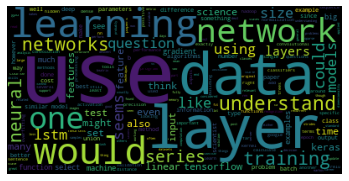

In [73]:
highest_wordcloud = WordCloud().generate_from_frequencies(distinct_highest_common_counter)
plt.figure()
plt.imshow(highest_wordcloud)
plt.axis("off")
plt.show()

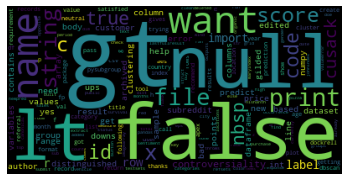

In [74]:
lowest_wordcloud = WordCloud().generate_from_frequencies(distinct_lowest_common_counter)
plt.figure()
plt.imshow(lowest_wordcloud)
plt.axis("off")
plt.show()

#Section 2: Spark, Hierarchical Data and Graph Data on Yelp Reviews Dataset

## Getting Started with Apache Spark

Now that you've seen how to run SQL queries through pandas, we'll working with running SQL in Apache Spark! Apache Spark is a complex, cluster-based data processing system written in Scala used for big data processing. For the most part, Spark interfaces “smoothly” to Python.

While Spark dataframes try to emulate the same programming style as Pandas DataFrames, there are some differences in how you express things. Please refer to the Lecture Slides or the following resources to learn about these differences:

https://lab.getbase.com/pandarize-spark-dataframes/
https://ogirardot.wordpress.com/2015/07/31/from-pandas-to-apache-sparks-dataframe/ 

For this assignment, we are going to get familiar with Spark without worrying too much about sharding and distribution. This isn’t really using it to its strengths -- and in fact you might find Spark to be slow -- but it will get you comfortable with programming in Spark without worrying about distributed nodes, clusters, and spending real dollars on the cloud. For Homework 3, we’ll connect your Jupyter instance to Spark running on the cloud.

### Initializing a Connection to Spark

We'll open a connection to Spark as follows. From `SparkSession`, you can load data into Spark DataFrames as well as `RDD`s.

Run the following cells to setup this part of the notebook!

In [75]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [76]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [77]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()

In [78]:
%load_ext sparkmagic.magics

In [79]:
import numpy as np
import pandas as pd
import matplotlib

# misc
import gc
import time
import warnings


# graph section
import networkx as nx
# import heapq  # for getting top n number of things from list,dict
import pandas as pd
import numpy as np

# JSON parsing
import json

# HTML parsing
from lxml import etree
import urllib

# SQLite RDBMS
import sqlite3

# Time conversions
import time

# Parallel processing
# import swifter

# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [80]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

### Download data

The following code retrieves the Yelp dataset files from Google Drive.

In [89]:
!rm yelp_business_attributes.csv
!rm yelp_business.csv
!rm yelp_checkin.csv
!rm yelp_review2.csv
!rm yelp_user.csv

!rm yelp_business_attributes.csv.1
!rm yelp_business.csv.1
!rm yelp_checkin.csv.1
!rm yelp_review2.csv.1
!rm yelp_user.csv.1

In [90]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(file_id='1XCANGSCd0pUNcXq18t2QDwCIpJxus8Dy',
#                                     dest_path='/content/yelp_business_attributes.csv')

# gdd.download_file_from_google_drive(file_id='11lwBibxX7PYGgOfHU25_dDDDsPX1Pt0Y',
#                                     dest_path='/content/yelp_business.csv')

# gdd.download_file_from_google_drive(file_id='1FU5Q-96erhTmk8SjC4XHUm94yWc6h3a0',
#                                     dest_path='/content/yelp_checkin.csv')

# gdd.download_file_from_google_drive(file_id='1UaaLrCKjqoQ7G3JT_VUw56pc-dnTwyrS', dest_path='/content/yelp_review2.csv')

# gdd.download_file_from_google_drive(file_id='1JNFZeLlimxNSwcOb-oBxxbwJqdg22WgD',
#                                     dest_path='/content/yelp_user.csv')

!wget https://penn-cis545-files.s3.amazonaws.com/yelp_business_attributes.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_business.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_checkin.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_review2.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_user.csv -P /content

--2020-10-13 15:09:24--  https://penn-cis545-files.s3.amazonaws.com/yelp_business_attributes.csv
Resolving penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)... 52.217.41.140
Connecting to penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)|52.217.41.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41377121 (39M) [text/csv]
Saving to: ‘/content/yelp_business_attributes.csv’

yelp_business_attri 100%[===================>]  39.46M  11.4MB/s    in 3.5s    

2020-10-13 15:09:28 (11.4 MB/s) - ‘/content/yelp_business_attributes.csv’ saved [41377121/41377121]

--2020-10-13 15:09:28--  https://penn-cis545-files.s3.amazonaws.com/yelp_business.csv
Resolving penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)... 52.216.136.244
Connecting to penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)|52.216.136.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31760674 

## Part 4: Working with Spark [21 points total]



### 4.1 Load Our Datasets


In this section, we'll be using Spark to look into social data from Yelp. To start, let's read our data into Spark. As an example of how to do this, to load the file `input.txt` into a Spark DataFrame, you can use lines like the following.

```
# Read lines from the text file
input_sdf = spark.read.load('input.txt', format="text")
```

We’ll use the suffix `_sdf` to represent “Spark DataFrame,” much as we used `_df` to denote a Pandas DataFrame. 


**TODO:** Load the various files from Yelp. Your datasets should be named `yelp_business_sdf`, `yelp_business_attributes_sdf`, `yelp_check_in_sdf`, `yelp_reviews_sdf`, and `yelp_users_sdf`. Submit the first 75 entries of the yelp_business_sdf, sorted by the "name" column in ascending order, to the autograder as a pandas dataframe by using the toPandas() function to convert it. 

In [91]:
!ls

Posts.xml		       Users.xml		     yelp_review2.csv
sample_data		       yelp_business_attributes.csv  yelp_user.csv
spark-3.0.1-bin-hadoop3.2      yelp_business.csv
spark-3.0.1-bin-hadoop3.2.tgz  yelp_checkin.csv


In [92]:
yelp_business_sdf = spark.read.load('yelp_business.csv', format = 'csv', header = True)
yelp_business_attributes_sdf = spark.read.load('yelp_business_attributes.csv', format = 'csv', header = True)
yelp_check_in_sdf = spark.read.load('yelp_checkin.csv', format = 'csv', header = True)
yelp_reviews_sdf = spark.read.load('yelp_review2.csv', format = 'csv', header = True)
yelp_users_sdf = spark.read.load('yelp_user.csv', format = 'csv', header = True)

In [93]:
yelp_business = yelp_business_sdf.toPandas().sort_values(by = ['name'], ascending = True)[:75]

In [94]:
grader.grade(test_case_id = 'check_yelp_load', answer = yelp_business[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


One key difference between using Pandas SQL and Spark SQL is that you'll need to create a view of your data before Spark is able to query it. Note that when using a temporary view as we will be doing, Spark does not persist the data in memory. 

**TODO:** Put all of your Spark dataframes from the previous section into temporary tables. The syntax is as follows:
*yelp_business_sdf.createOrReplaceTempView('yelp_business')*

Note that when you're accessing the yelp data within Spark SQL later in the homework you'll want to refer to each table as the name of the view you assigned - for instance "yelp_business" not "yelp_business_sdf". This distinction is important as this table is only visible to Spark as "yelp_business".

In [95]:
# TODO: save tables with names such as yelp_business, yelp_users
yelp_business_sdf.createOrReplaceTempView('yelp_business')
yelp_business_attributes_sdf.createOrReplaceTempView('yelp_business_attributes')
yelp_check_in_sdf.createOrReplaceTempView('yelp_check_in')
yelp_reviews_sdf.createOrReplaceTempView('yelp_reviews')
yelp_users_sdf.createOrReplaceTempView('yelp_users')

Next, explore the sdf's using the Sandbox area below. Some functions that might be useful are:
* show (shows the first few rows of data, similar to head in Pandas)
* count (counts number of rows, similar to using len in Pandas)
* dtypes (same as in Pandas) 
* describe (use with show to see summary statistics, similar to just describe on its own in Pandas)

You are not limited to these functions and are welcome to use any other ones. The purpose of this exploration is to get a sense of what the data looks like before moving on. Again, **this section is not graded**, but we encourage you to get familiar with the data before diving in.


In [96]:
# your EDA here! feel free to add more cells
yelp_business_sdf.show(3)

+--------------------+--------------------+------------+--------------------+----------+---------+-----------+----------+-----------+------------+------------+-------+--------------------+
|         business_id|                name|neighborhood|             address|      city|    state|postal_code|  latitude|  longitude|       stars|review_count|is_open|          categories|
+--------------------+--------------------+------------+--------------------+----------+---------+-----------+----------+-----------+------------+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|"""Dental by Desi...|        null| """4855 E Warner Rd| Ste B9"""|Ahwatukee|         AZ|     85044| 33.3306902|-111.9785992|         4.0|     22|                   1|
|He-G7vWjzVUysIKrf...|"""Stephen Szabo ...|        null|"""3101 Washingto...|  McMurray|       PA|      15317|40.2916853|-80.1048999|         3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|"""Western Motor ...|        null

### 4.2 Simple Analytics on the Data
In this section, we will be executing Spark operations on the data given. Beyond simply executing the queries, you may try using .explain() method to see more about the query execution. Also, please read the data description prior to attempting the following questions to understand the data.

#### 4.2.1 Spark and Big Data
You may be wondering why we can't just use Pandas SQL for analytics on the yelp data. As the data we're working with gets larger data, performance in Pandas will slow - or the data may even be too large to load into Pandas.

For a simple example, let's compare how long the same query takes to run in Pandas SQL and Spark SQL.

**TODO:** First, convert the yelp business table to Pandas. Then, using the yelp business table, select the name of businesses located in Pennsylvania. Run this query in both Pandas SQL and Spark SQL and time how long the query takes to run. The time module will be useful for this. You may want to separate your code into several cells to ensure you are only timing one query at a time. Submit the ratio of the time it took the query to run in Pandas SQL to the time it took the query to run in Spark SQL, called `time_ratio`, to the autograder.

As a reminder, Spark uses lazy computation, meaning results are delayed until they are actually needed. Therefore, you will need to show your table (or do some other computation that requires the table to be generated) in order for your query to run in Spark.

In [97]:
import time

In [98]:
# Convert the yelp_business_sdf to Pandas 
yelp_business_df = yelp_business_sdf.toPandas()

In [99]:
# Time the query takes to run in Pandas SQL
start_time = time.time()
PA_businesses_pandas = yelp_business_df[yelp_business_df['state'] == 'PA'] ['name']
end_time = time.time()
pandas_time = end_time - start_time

In [100]:
# Time the query takes to run in Spark SQL
query = \
'''
SELECT name 
FROM yelp_business
WHERE state == 'PA'
'''
start_time = time.time()
PA_businesses_spark = spark.sql(query).show()
end_time = time.time()
spark_time = end_time - start_time

+--------------------+
|                name|
+--------------------+
|"""Stephen Szabo ...|
|"""Any Given Sund...|
|"""East Coast Cof...|
|"""Complete Denta...|
|"""Carrabba's Ita...|
|"""Enterprise Ren...|
|"""River Moon Caf...|
|"""Crazy Mocha Co...|
|"""Bruegger's Bag...|
|         """Blush"""|
|      """T.W.Tile"""|
|"""Coraopolis Col...|
|"""Police Station...|
|"""Napoli Pizzeri...|
|"""Sheraton Great...|
|        """Allure"""|
|"""Double Take Au...|
|"""Coyle Auto Bod...|
|     """Pizza Hut"""|
|  """Shear Talent"""|
+--------------------+
only showing top 20 rows



In [101]:
# Ratio of time taken in Pandas SQL to time taken in SPark SQL

time_ratio = spark_time/pandas_time

In [102]:
grader.grade(test_case_id = 'time_check', answer = time_ratio)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 4.2.2 Cities by number of businesses

Next, we'll explore which cities have the most restaurants. 

**TODO:** Find the top 10 cities by number of (Yelp-listed) businesses. This table should include `city`, `state`, and `num_restaurants`, which is the number of restaurants in the city. Convert this sdf to Pandas and submit top10_cities_df to the autograder. Remember to only convert small tables to Pandas!


Your table should look something like:
>city | state | num_restaurants
>--- | --- |--- 
>city 1 | state 1|  rating 1 | number 1
>city 2| state 2| rating 2 | number 2




In [103]:
query = \
'''
SELECT city, 
state, 
COUNT(business_id) AS num_restaurants 
FROM yelp_business 
GROUP BY city, state
ORDER BY COUNT(business_id) DESC LIMIT 10
'''

top10_cities_df = spark.sql(query)
top10_cities_df = top10_cities_df.toPandas()

In [104]:
grader.grade(test_case_id = 'top10CitiesCheck', answer = top10_cities_df)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 4.2.3 Business ratings across states

Next, we'll be looking into how ratings for the same business vary state by state. Throughout this problem, we'll be intersted in the *average rating by business and by state*. 

**TODO:** For each business, find the states where the business's average rating is below the *maximum of the business's per-state* average rating.  Think about how to factor that into steps!

* Compute the average rating for each business name by state. For each business, find the maximum average rating across all states' average ratings. 

* Then compute an sdf containing the business name, state, avg_rating, and max_avg_rating for businesses in states where that business is *not* most highly rated. Order the output in order of business name, decreasing avg_rating, and increasing state name. 

Convert the top 100 rows to Pandas and submit `below_avg_states_df` to the autograder.

Your table should look something like:
>name | state |avg_rating | max_avg_rating
>--- | --- |--- | ---
>business name 1 | state 1|  rating 1 | maxing rating 1
>business name 1 | state 2| rating 2 | maxing rating 1
>business name 2 | state 3| rating 3 | maxing rating 2


In [105]:
yelp_business_sdf.show(5)

+--------------------+--------------------+------------+--------------------+--------------+---------+-----------+----------+-----------+------------+------------+-------+--------------------+
|         business_id|                name|neighborhood|             address|          city|    state|postal_code|  latitude|  longitude|       stars|review_count|is_open|          categories|
+--------------------+--------------------+------------+--------------------+--------------+---------+-----------+----------+-----------+------------+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|"""Dental by Desi...|        null| """4855 E Warner Rd|     Ste B9"""|Ahwatukee|         AZ|     85044| 33.3306902|-111.9785992|         4.0|     22|                   1|
|He-G7vWjzVUysIKrf...|"""Stephen Szabo ...|        null|"""3101 Washingto...|      McMurray|       PA|      15317|40.2916853|-80.1048999|         3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|"""Western Mo

In [106]:
query_1 = \
'''
SELECT name,
state,
AVG(stars) AS avg_rating
FROM yelp_business
GROUP BY name, state
'''

table_1_sdf = spark.sql(query_1)
table_1_sdf.createOrReplaceTempView('table_1')

query_2 = \
'''
SELECT t1.name, 
MAX(t1.avg_rating) AS max_avg_rating
FROM (
  SELECT name,
  state,
  AVG(stars) AS avg_rating
  FROM yelp_business
  GROUP BY name, state
) t1
GROUP BY name
'''

table_2 = spark.sql(query_2)
table_2_sdf = spark.sql(query_2)
table_2_sdf.createOrReplaceTempView('table_2')

query = \
'''
SELECT table_1.name,
table_1.state,
table_1.avg_rating,
table_2.max_avg_rating
FROM table_1 
INNER JOIN table_2
ON table_1.name == table_2.name
WHERE avg_rating < max_avg_rating
ORDER BY name, avg_rating DESC, state
LIMIT 100
'''

below_avg_states_df = spark.sql(query)
below_avg_states_df = below_avg_states_df.toPandas()
below_avg_states_df.head(10)

,name,state,avg_rating,max_avg_rating
0,"""""""007 Nails""""""",Madison,-89.308984,4.000000
1,"""""""1-800-Flowers""""""",Chandler,-111.857970,1.500000
2,"""""""1-800-PACK-RAT""""""",NV,3.000000,4.000000
3,"""""""1-800-PACK-RAT""""""",Charlotte,-80.978899,4.000000
4,"""""""1-800-PACK-RAT""""""",Phoenix,-112.124813,4.000000
5,"""""""180 Smoke Vape Store""""""",Toronto,-79.471043,2.500000
6,"""""""2 Gals Kitchen""""""",Concord,-80.590494,4.500000
7,"""""""20 Lounge""""""",Scottsdale,-111.924064,33.539848
8,"""""""20/20 Image Eye Centers""""""",Fountain Hills,-111.720898,3.000000
9,"""""""20/20 Image Eye Centers""""""",Scottsdale,-111.880040,3.000000


In [107]:
grader.grade(test_case_id = 'check_by_state_rating', answer = below_avg_states_df)

Correct! You earned 9/9 points. You are a star!

Your submission has been successfully recorded in the gradebook.


###4.3 Format Yelp Data as a Graph


The Yelp data you've been working with can be thought of as graph data. Recall that a graph is made up of a set of verticies that are connected by edges. Within the context of our data, we can think of the users/businesses as nodes. Edges would then represent a review by a user for a business.

With this in mind, we now want to reformat the yelp_reviews dataset to look more like a graph. 

**TODO:** Use Spark SQL to rename the user_id column of yelp_reviews data to from_node and rename the business_id column to to_node. Filter to rows where both the user_id and business_id are not null.  Create a temporary view with this table.

Your table should look something like:
>from_node | to_node | score
>--- | --- | ---
>user id 1 | business id 1 | stars 1
>user id 2 | business id 2 | stars 2



In [108]:
yelp_reviews_sdf.show(5)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|     0|    0|   0|
+--------------------+----------

In [109]:
query = \
'''
SELECT user_id AS from_node,
business_id AS to_node,
stars AS score
FROM yelp_reviews
WHERE user_id IS NOT NULL AND business_id IS NOT NULL
'''

review_graph_sdf = spark.sql(query)

In [110]:
review_graph_sdf.show(10)

+--------------------+--------------------+-----+
|           from_node|             to_node|score|
+--------------------+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|
|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|
|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|
|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|
|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|
|_4iMDXbXZ1p1ONG29...|8QWPlVQ6D-OExqXoa...|    5|
|u0LXt3Uea_GidxRW1...|9_CGhHMz8698M9-Pk...|    4|
|u0LXt3Uea_GidxRW1...|gkCorLgPyQLsptTHa...|    4|
|u0LXt3Uea_GidxRW1...|5r6-G9C4YLbC7Ziz5...|    3|
|u0LXt3Uea_GidxRW1...|fDF_o2JPU8BR1Gya-...|    5|
+--------------------+--------------------+-----+
only showing top 10 rows



**TODO:** Once you've made your graph and created a temporary view, use Spark SQL to filter to the rows in the graph that contain the sequence "abc" anywhere in the from_node. Convert this subset to a Pandas dataframe called named `review_graph_abc`  and submit this to the autograder.

HINT: Look into the LIKE keyword and wildcards in SQL. 




In [111]:
review_graph_abc_sdf = review_graph_sdf.filter("from_node LIKE '%abc%'")

review_graph_abc = review_graph_abc_sdf.toPandas()

In [112]:
# Add test case for making graph
grader.grade(test_case_id = 'reviewGraphCheck', answer = review_graph_abc)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.



## Part 5. “Traversing” a Graph [21 points total]

For our next tasks, we will be “walking” the graph and making connections.




### 5.1 Intro to Distributed Breadth-First Search


Now that we have created our graph, we will be implementing a graph traversal algorithm known as Breadth First Search. It works in a way that's equivalent to how a stain spreads on a white t-shirt. Take a look at the graph below:

<p align = "center">
<img src = "https://imgur.com/WU3AUwg.png" width= "600" align ="center"/>

* Consider starting BFS from point A (green). This is considered the starting frontier/singular origin node.
* The first round of BFS would involve finding all the nodes directly reachable from A, namely B-F (blue circles). These blue nodes make up the next frontier at depth 1 away from our starting node A.
* The second round would then be identifying the red nodes which are the neighbors of the blue nodes. Now, the red nodes all belong to a frontier 2 depth away from A.

This process continues until all the nodes in the graph have been visited. 


If you would like to learn more about BFS, I highly suggest looking [here](https://www.tutorialspoint.com/data_structures_algorithms/breadth_first_traversal.html).


We will now be implementing **spark_bfs(G, N, d)**, our spark flavor of BFS that takes a graph **G**, a set of origin nodes **N**, and a max depth **d**.

In order to write a successful BFS function, you are going to need to figure out 
1. how to keep track of nodes that we have visited
2. how to properly find all the nodes at the next depth
3. how to avoid cycles and ensure that we do not constantly loop through the same edges (take a look at J-K in the graph)


### 5.2 Implement one Traversal

To break down this process, let's think about how we would implement a single traversal of the graph. That is given the green node in the graph above, how are we going to get the blue nodes?


Consider the simple graph below **which is different from the graph in the image above**:

In [114]:
simple = [('A', 'B'),
         ('A', 'C'),
         ('A', 'D'),
         ('C', 'F'),
         ('F', 'A'),
         ('B', 'G'),
         ('G', 'H'),
         ('D', 'E')]
simple_dict = {'from_node': ['A', 'A', 'A', 'C', 'F', 'B', 'G', 'D'],
       'to_node': ['B', 'C', 'D', 'F', 'A', 'G', 'H', 'E']}
simple_graph_df = pd.DataFrame.from_dict(simple_dict)
simple_graph_sdf = spark.createDataFrame(simple_graph_df)
simple_graph_sdf.show()

+---------+-------+
|from_node|to_node|
+---------+-------+
|        A|      B|
|        A|      C|
|        A|      D|
|        C|      F|
|        F|      A|
|        B|      G|
|        G|      H|
|        D|      E|
+---------+-------+



As you can see, each row of this dataframe represents an edge between two nodes Although the nodes are labeled "from" and "to", the edges are actually undirected, meaning that A-->B represents the same edge as B-->A.

Let's define our starting node as follows:

In [115]:
smallOrig = [{'node': 'A'}]

Then, bfs with graph G, starting from smallOrig to depth 1, or  **spark_bfs(G, smallOrig, 1)** would output as follows:

In [116]:
simple_1_round_dict = {'node': ['F', 'B', 'D', 'C', 'A'],
       'distance': [1, 1, 1, 1, 0]}
simple_1_round_bfs_df = pd.DataFrame.from_dict(simple_1_round_dict)
simple_1_round_bfs_sdf = spark.createDataFrame(simple_1_round_bfs_df)
simple_1_round_bfs_sdf.show()

+----+--------+
|node|distance|
+----+--------+
|   F|       1|
|   B|       1|
|   D|       1|
|   C|       1|
|   A|       0|
+----+--------+



As you can see, this dataframe logs each node with its corresponding distance away from A. Moreover, we also know that these nodes are **visited**. 

Hopefully, you can see how we can use our original graph and this new information to find the nodes at depth two. 

This is exactly what we will try to accomplish with **spark_bfs_1_round(visited_nodes)** which will ultimately be the inner function of **spark_bfs** that we use to perform exactly one traversal of a graph.

**TODO**: Write **spark_bfs_1_round(visted_nodes)** that takes the currently dataframe of visited_nodes, performs one round of BFS, and returns an updated visited nodes dataframe. You should assume that a temporary sdf G already exists.

In [117]:
simple_graph_sdf.show()

+---------+-------+
|from_node|to_node|
+---------+-------+
|        A|      B|
|        A|      C|
|        A|      D|
|        C|      F|
|        F|      A|
|        B|      G|
|        G|      H|
|        D|      E|
+---------+-------+



In [118]:
simple_1_round_bfs_sdf.show()

+----+--------+
|node|distance|
+----+--------+
|   F|       1|
|   B|       1|
|   D|       1|
|   C|       1|
|   A|       0|
+----+--------+



In [130]:
def spark_bfs_1_round(visited_nodes):
  """
  :param visited_nodes: dataframe with columns node and distance
  :return: dataframe of updated visited nodes, with columns node and distance
  """
  
  visited_nodes.createOrReplaceTempView('visited_nodes')

  query = \
  '''
  SELECT G.to_node AS node,
  visited_nodes.distance + 1 AS distance
  FROM visited_nodes INNER JOIN G 
  ON visited_nodes.node == G.from_node
  '''

  visited_nodes = spark.sql(query)

  return visited_nodes

Now, run the inner function on **simple_1_round_bfs_sdf** result of 1 round of BFS on simple graph and store the results in **simple_bfs_result**. This is ultimately what the output of BFS to depth 2 should look like.

In [131]:
smallOrig = [{'node': 'A', 'distance': 0}]
smallOrig_df = pd.DataFrame.from_dict(smallOrig)
smallOrig_sdf = spark.createDataFrame(smallOrig_df)
smallOrig_sdf.show()

+----+--------+
|node|distance|
+----+--------+
|   A|       0|
+----+--------+



In [132]:
simple_graph_sdf.createOrReplaceTempView('G')
simple_bfs_result = spark_bfs_1_round(smallOrig_sdf)
simple_bfs_result.show()

+----+--------+
|node|distance|
+----+--------+
|   B|       1|
|   C|       1|
|   D|       1|
+----+--------+



Convert this result to Pandas, sorted by the node, and submit it to the autograder.

In [ ]:
simple_bfs_test = # TODO

In [ ]:
grader.grade(test_case_id = 'checksimpleBFS', answer = simple_bfs_test)

### 5.3 Full BFS Implemntation

Now, we will fully implement **spark_bfs**. This function should iteratively call your implemented version of **spark_bfs_1_round** and ultimately return the output of this function at **max_depth**.

You are also responsible for initializing the starting dataframe, that is converting the list of origin nodes into a spark dataframe with the nodes logged at distance 0.

Consider the following: 

```
schema = StructType([
            StructField("node", StringType(), True)
        ])

    my_sdf = spark.createDataFrame(origins, schema)
```

The schema ultimately specifies the structure of the Spark DataFrame with a string `node` column. It then calls **spark.createDataFrame** to map this schema to the **origins** nodes. Also, you are responsible for ensuring that a view of your graph is available within this function. (Note: you will also need to add in a distance column)

**TODO:** implement **spark_bfs(G,origins,max_depth)** and run on **review_graph_sdf** initalized in 4.3. Note: you may want to run tests on the **simple_graph** example as the `review_graph_sdf` will take quite some time to run.

In [ ]:
# TODO: iterative search over undirected graph
# Worth 5 points directly, but will be needed later

def spark_bfs(G, origins, max_depth):
  """ runs distributed BFS to a specified max depth

  :param G: graph dataframe from 4.3
  :param origins: list of origin nodes stored as {"node": nodeValue}
  :param max_depth: integer value of max depth to run BFS to
  :return: dataframe with columns node, distance of all visited nodes
  """

  # TODO 


Test that this function works on the simple example first. 

In [ ]:
simple_bfs_iterative_result = spark_bfs(simple_graph_sdf, smallOrig, 3)
simple_bfs_iterative_result.show()

**TODO**: Using the starting node defined below, create **bfs_3** as the result of running **sparkbfs** on **review_graph_sdf** to a depth of 3. Finally, create a pandas dataframe of the first 75 results sorted by id as **answer_75_df** and submit this to the autograder.

In [ ]:
orig = [{'node': 'bv2nCi5Qv5vroFiqKGopiw'}]
# grab the count
bfs_3 = # TODO

In [ ]:
answer_75_df = # TODO

When submitting to the autograder, submit as a tuple where first value is the length of your output dataframe and the second is the first 75 rows of your result.

However, before you grab your first 75 rows, sort by the ids

In [ ]:
# 13603 is just obtained from running count.count()
grader.grade(test_case_id = 'checkBFS', answer = (length, answer_75_df))

Congratulations on making it to the end of Homework 2! Feel free to fill out [this form](https://forms.gle/DbDuEbqqifoFrRxaA) with any feedback for this and prior homeworks. We know this assignment was pretty dense, but we hope that you still managed to learn a lot from it :)
